In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import PchipInterpolator

In [2]:
# 1. SETUP DATA
# ==========================================
# Standard wind steps usually associated with 9-column data
# Adjust these if your certificate is different (e.g. starts at 4kts)
tws_speeds = [6, 8, 10, 12, 14, 16, 20, 24, 30]

raw_data = {
    'beat_angle': [42.1, 42.1, 40.4, 39.8, 39.6, 39.2, 39.1, 39.7, 41.1],
    'beat_vmg':   [2.59, 3.48, 4.10, 4.46, 4.64, 4.72, 4.75, 4.71, 4.58],
    52:  [3.95, 5.21, 6.02, 6.44, 6.64, 6.73, 6.77, 6.77, 6.71],
    60:  [4.15, 5.44, 6.23, 6.62, 6.82, 6.92, 6.96, 6.99, 6.97],
    75:  [4.30, 5.60, 6.37, 6.76, 6.99, 7.14, 7.23, 7.33, 7.38],
    90:  [4.20, 5.51, 6.33, 6.80, 7.04, 7.24, 7.40, 7.64, 7.76],
    110: [4.13, 5.56, 6.53, 7.01, 7.32, 7.56, 7.71, 7.96, 8.11],
    120: [4.00, 5.43, 6.44, 6.97, 7.31, 7.62, 7.90, 8.27, 8.55],
    135: [3.52, 4.90, 6.00, 6.71, 7.12, 7.45, 7.77, 8.43, 9.18],
    150: [2.94, 4.15, 5.21, 6.10, 6.70, 7.06, 7.34, 7.90, 8.52],
    'run_vmg':    [2.54, 3.60, 4.51, 5.28, 5.83, 6.25, 6.59, 7.14, 7.63],
    'gybe_angle': [144.2, 144.2, 148.0, 149.3, 153.1, 159.0, 163.0, 176.2, 175.9]
}

# Fixed angles provided in the data
fixed_angles = [52, 60, 75, 90, 110, 120, 135, 150]

In [3]:
def get_curve_data(index):
    """
    Extracts and calculates (Angle, Speed) pairs for a specific 
    wind speed column index (0-8).
    """
    angles = []
    speeds = []
    
    # 1. Optimal Upwind (Beat)
    ba = raw_data['beat_angle'][index]
    bv = raw_data['beat_vmg'][index]
    # Calculate Speed from VMG: Speed = VMG / cos(theta)
    # Note: cos takes radians
    bs = bv / np.cos(np.radians(ba))
    
    angles.append(ba)
    speeds.append(bs)
    
    # 2. Fixed Angles
    for ang in fixed_angles:
        angles.append(ang)
        speeds.append(raw_data[ang][index])
        
    # 3. Optimal Downwind (Run/Gybe)
    ga = raw_data['gybe_angle'][index]
    rv = raw_data['run_vmg'][index]
    # Calculate Speed from VMG: Speed = VMG / |cos(theta)|
    rs = rv / abs(np.cos(np.radians(ga)))
    
    angles.append(ga)
    speeds.append(rs)
    
    # 4. Sort by Angle
    # Because Gybe angle (e.g., 144.2) might be less than 150 fixed angle
    # we must sort them to get a clean line for interpolation
    data_pairs = sorted(zip(angles, speeds))
    sorted_angles, sorted_speeds = zip(*data_pairs)
    
    return np.array(sorted_angles), np.array(sorted_speeds)

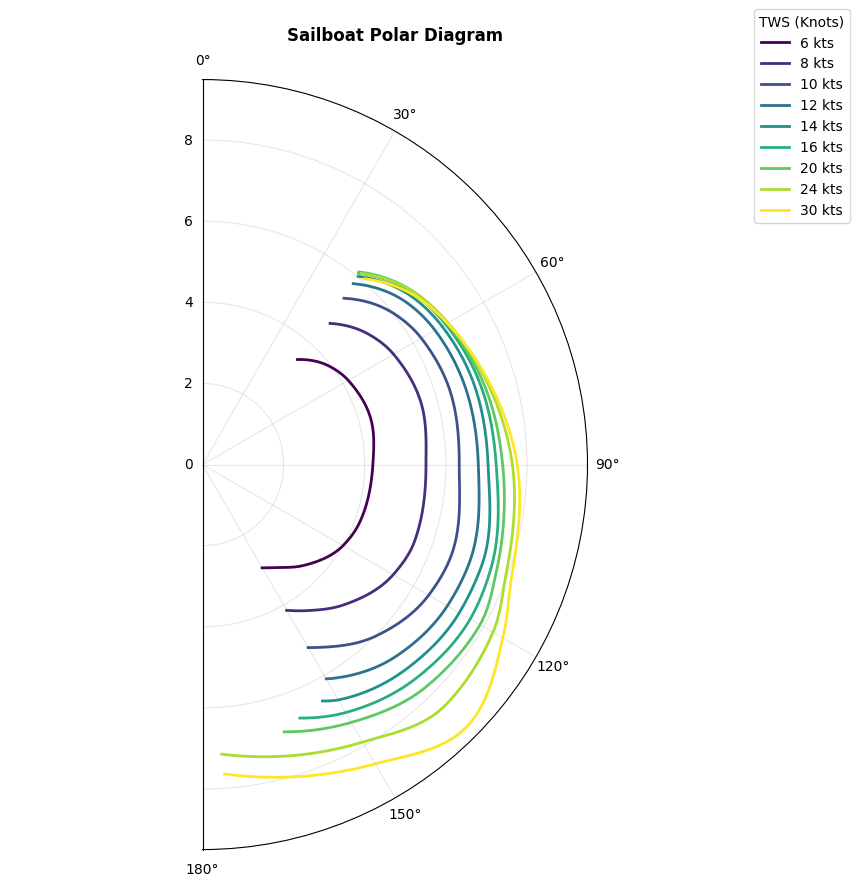

In [4]:
fig, ax = plt.subplots(subplot_kw={'projection': 'polar'}, figsize=(10, 10))

# Set 0 degrees to be at the top (North)
ax.set_theta_zero_location("N")
# Make angles go clockwise (Standard for sailing polars)
ax.set_theta_direction(-1)

# Set limits
ax.set_thetamin(0)
ax.set_thetamax(180)
ax.set_rlabel_position(90)  # Move radial labels to the side

# Create a color map for the wind speeds
colors = plt.cm.viridis(np.linspace(0, 1, len(tws_speeds)))

for i, tws in enumerate(tws_speeds):
    # Get the raw points for this wind speed
    x_deg, y_speed = get_curve_data(i)
    
    # Create interpolation
    # We use PchipInterpolator for monotonic interpolation to prevent
    # the line from "wiggling" unrealistically between points
    interpolator = PchipInterpolator(x_deg, y_speed)
    
    # Generate smooth range of angles for plotting
    # From the smallest angle (beat) to largest (gybe or 150)
    x_smooth_deg = np.linspace(x_deg.min(), x_deg.max(), 100)
    y_smooth_speed = interpolator(x_smooth_deg)
    
    # Convert degrees to radians for matplotlib polar plot
    x_smooth_rad = np.radians(x_smooth_deg)
    
    # Plot
    ax.plot(x_smooth_rad, y_smooth_speed, label=f"{tws} kts", color=colors[i], linewidth=2)
    
    # Optional: Plot the actual raw dots to see data fit
    # ax.plot(np.radians(x_deg), y_speed, 'o', color=colors[i], markersize=3, alpha=0.6)

# Formatting
ax.set_title("Sailboat Polar Diagram", va='bottom', fontweight='bold')
ax.legend(loc='upper right', bbox_to_anchor=(1.1, 1.1), title="TWS (Knots)")
ax.grid(True, alpha=0.3)

plt.show()